In [1]:
import pandas as pd
import tensorflow as tf

IMAGE_SIZE = 28
NUM_CLASSES = 10
BATCH_SIZE = 40

raw_train = pd.read_csv("fashion-mnist_train.csv")
raw_test = pd.read_csv("fashion-mnist_test.csv")

In [2]:
raw_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def transform(raw_df):
    labels, images = raw_df.iloc[:, 0].values, raw_df.iloc[:, 1:].values
    return images, labels

In [4]:
train_x, train_y = transform(raw_train)
test_x, test_y = transform(raw_test)

<AxesSubplot:ylabel='Frequency'>

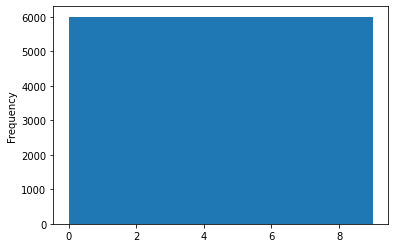

In [5]:
raw_train["label"].plot.hist()

In [6]:
def create_dataset(images, labels, training=True, reshape=True):
    if reshape:
        images = images.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
    one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=NUM_CLASSES)
    ds = tf.data.Dataset.from_tensor_slices(((images), (one_hot_labels)))
    if training:
        ds = ds.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size=BATCH_SIZE)
    return ds  

In [7]:
train_ds = create_dataset(train_x, train_y, reshape=False)
test_ds = create_dataset(test_x, test_y, reshape=False, training=False)

train_ds_cnn = create_dataset(train_x, train_y, reshape=True)
test_ds_cnn = create_dataset(train_x, train_y, reshape=True, training=False)

In [8]:
train_ds.take(1)

<TakeDataset shapes: ((None, 784), (None, 10)), types: (tf.int64, tf.float32)>

In [9]:
train_ds_cnn.take(1)

<TakeDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.int64, tf.float32)>

In [10]:
class DenseModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.preprocess = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
        self.encoders = [
            tf.keras.layers.BatchNormalization(trainable=tf.keras.backend.learning_phase()),
            *[tf.keras.layers.Dense(units, activation=tf.nn.relu) for units in (28, 56, 84)]
        ]
        self.softmax = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax)

    def call(self, inputs, training=True):
        inputs = self.preprocess(inputs)
        hidden = self.encoders[0](inputs)
        for l in self.encoders[1:]:
            hidden = l(hidden)
        return self.softmax(hidden)
    


In [11]:
model = DenseModel()

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=["accuracy"]
)

In [12]:
model.fit(x=train_ds, use_multiprocessing=True, verbose=False, epochs=15)

In [13]:
model.evaluate(x=test_ds, batch_size=30)

250/250 [==============================] - 0s 922us/step - loss: 0.4171 - accuracy: 0.8564


[0.4170991778373718, 0.8564000129699707]

In [24]:
class CNNModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.preprocess = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
        self.encoders = [
            tf.keras.layers.BatchNormalization(trainable=tf.keras.backend.learning_phase()),
            tf.keras.layers.Conv2D(32, 3),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.BatchNormalization(trainable=tf.keras.backend.learning_phase()),
            tf.keras.layers.Conv2D(64, 3),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
        ]
        self.logits = tf.keras.layers.Dense(128, activation='relu',  kernel_initializer='he_uniform')

        self.softmax = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")

    def call(self, inputs, training=True):
        inputs = self.preprocess(inputs)        
        hidden = self.encoders[0](inputs)
        for layer in self.encoders[1:]:
            hidden = layer(hidden)
        logits = self.logits(hidden)
        return self.softmax(logits)

In [25]:
cnn_model = CNNModel()
cnn_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"]
)

In [26]:
cnn_model.fit(x=train_ds_cnn, use_multiprocessing=True, epochs=25, verbose=0)
cnn_model.summary()

Model: "cnn_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      multiple                  0         
_________________________________________________________________
batch_normalization_3 (Batch multiple                  4         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  320       
_________________________________________________________________
activation_2 (Activation)    multiple                  0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
batch_normalization_4 (Batch multiple                  128       
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  

In [27]:
cnn_model.evaluate(x=test_ds_cnn, batch_size=30)

1500/1500 [==============================] - 9s 5ms/step - loss: 0.2305 - accuracy: 0.9141


[0.23046399652957916, 0.9141166806221008]